Simple GPT model written from scratch and trained in a corpus of Shakespeare text.

### Tokenizer

In [1]:
import re
class BPE_regex:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges_map = dict()
        self.vocabulary = {idx: bytes([idx]) for idx in range(256)}
        self.pat = r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| \d+| ?[^\s\w\d]+|\s+(?!\S)|\s+" # contractions, words, numbers, punctuation, continued spaces except 
        # the last space so it doesn't destroy the structure where a word or number starts with a space, and finally continued spaces at the end of the string 

    def decode(self, encoded):
        # Join the bytes as a string of bytes and then decode
        return b''.join([self.vocabulary[idx] for idx in encoded]).decode('utf-8', errors='replace')
    
    def encode(self, text):
        tokens = []
        for token in re.findall(self.pat, text, re.IGNORECASE):
            tokens.extend(tokenizer._encode(token))
        return tokens
    
    def _encode(self, text):
        # Transform string to a list of bytes
        encoded = list(text.encode('utf-8'))

        while len(encoded) > 1:
            # Find the pair that should be merged first: It is the pair that has the lowest id in the vocabulary
            pairs = set()
            for pair in zip(encoded[:-1], encoded[1:]):
                pairs.add(pair)
            pair_to_merge = min(pairs, key=lambda pair: self.merges_map.get(pair, float('inf'))) # The pair with the lowest index

            # If there is no pair to merge break out of the loop
            if pair_to_merge not in self.merges_map:
                break

            # Replace each merged token one by one in the merged order
            new_tokens = []
            i = 0
            while i < len(encoded):
                pair = encoded[i], encoded[i+1] if i < len(encoded) -1 else None # if is the last position pair is None
                # If there is pair to merge add the proper id and advance i to skip the tail of the pair
                if pair is not None and pair == pair_to_merge:
                    new_tokens.append(self.merges_map[pair_to_merge])
                    i += 1
                # If there is no pair to merge, add the id i in the ith position
                else:
                    new_tokens.append(encoded[i])
                # Go to the next id
                i += 1
            encoded = new_tokens

        return encoded

    def train(self, corpus):
        pre_tokens = re.findall(self.pat, corpus, re.IGNORECASE)
        new_encoded = [list(tok.encode('utf-8')) for tok in pre_tokens]

        vocab_size = 256 # initial vocab_size is the number of bytes
        while vocab_size < self.vocab_size:
            # Count pairs
            counts = {}
            for fragment in new_encoded:
                for pair in zip(fragment[:-1], fragment[1:]):
                    counts[pair] = counts.get(pair, 0) + 1
            # Get the pair to create the new token
            max_pair = max(counts, key=counts.get)

            # Save the new token
            new_tok_id = vocab_size
            self.vocabulary[new_tok_id] = self.vocabulary[max_pair[0]] + self.vocabulary[max_pair[1]] # Concatenate the bytes
            self.merges_map[max_pair] = new_tok_id
            vocab_size += 1

            # Check if there is any merging to do
            new_tokens = []
            for fragment in new_encoded:
                fragment_tokens = []
                i = 0
                while i < len(fragment):
                    pair = fragment[i], fragment[i+1] if i < len(fragment) -1 else None # if is the last position pair is None
                    if pair is not None and pair == max_pair:
                        fragment_tokens.append(new_tok_id)
                        i += 1
                    else:
                        fragment_tokens.append(fragment[i])
                    i += 1
                new_tokens.append(fragment_tokens)
            new_encoded = new_tokens


with open('shakespeare.txt') as file:
    corpus = file.read()
tokenizer = BPE_regex(2000)
# tokenizer.train(corpus)

In [2]:
import pickle
with open('bpe_shakes', 'rb') as f:
    tokenizer = pickle.load(f)

In [3]:
tokenizer.decode(tokenizer.encode(corpus)) == corpus

True

In [4]:
tokenizer.vocabulary

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

block_size = 256
emb_dim = 384
batch_size = 64
head_dim = 384
blocks_num = 6
heads_num = 6
droput = 0.4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# Create the dataset
stoi = {s:i for i,s in tokenizer.vocabulary.items()}
print(len(tokenizer.vocabulary))

tokenized = torch.tensor(tokenizer.encode(corpus))
n = int(0.9*len(tokenized))
train_data = tokenized[:n]
val_data = tokenized[n:]
print(len(train_data), len(val_data))

2000
351411 39046


In [8]:
# Visualize the tokenization
[tokenizer.vocabulary[idx.item()] for idx in train_data[:100]]

[b'First',
 b' Citizen',
 b':',
 b'\n',
 b'Be',
 b'fore',
 b' we',
 b' pro',
 b'ceed',
 b' any',
 b' fur',
 b'ther',
 b',',
 b' hear',
 b' me',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'Sp',
 b'eak',
 b',',
 b' speak',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'You',
 b' are',
 b' all',
 b' res',
 b'ol',
 b'ved',
 b' rather',
 b' to',
 b' die',
 b' than',
 b' to',
 b' f',
 b'am',
 b'ish',
 b'?',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'R',
 b'es',
 b'ol',
 b'ved',
 b'.',
 b' res',
 b'ol',
 b'ved',
 b'.',
 b'\n',
 b'\n',
 b'First',
 b' Citizen',
 b':',
 b'\n',
 b'First',
 b',',
 b' you',
 b' know',
 b' C',
 b'a',
 b'ius',
 b' Marcius',
 b' is',
 b' chi',
 b'ef',
 b' enemy',
 b' to',
 b' the',
 b' people',
 b'.',
 b'\n',
 b'\n',
 b'All',
 b':',
 b'\n',
 b'We',
 b' know',
 b"'t",
 b',',
 b' we',
 b' know',
 b"'t",
 b'.',
 b'\n',
 b'\n',
 b'First']

In [9]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) # For every letter, the target is the letter to the right
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

x, y = get_batch('train')
x.shape, y.shape # Check how for each data element (64 features) there are 64 targets. Thats is because self-attention generates an output for each position (this can be used to make the prediction of the next token)

(torch.Size([64, 256]), torch.Size([64, 256]))

In [10]:
# Examples:
for i in range(8):
    print(f'\n\nEXAMPLE {i+1}:')
    for j in range(x.shape[1]):
        print(f'{tokenizer.decode(x[i,:j+1].cpu().numpy())} -> {tokenizer.decode([y[i,j].item()])}')



EXAMPLE 1:
 in -> !
 in! -> 

 in!
 -> 

 in!

 -> SICINIUS
 in!

SICINIUS -> :
 in!

SICINIUS: -> 

 in!

SICINIUS:
 -> We
 in!

SICINIUS:
We ->  hear
 in!

SICINIUS:
We hear ->  not
 in!

SICINIUS:
We hear not ->  of
 in!

SICINIUS:
We hear not of ->  him
 in!

SICINIUS:
We hear not of him -> ,
 in!

SICINIUS:
We hear not of him, ->  ne
 in!

SICINIUS:
We hear not of him, ne -> ither
 in!

SICINIUS:
We hear not of him, neither ->  need
 in!

SICINIUS:
We hear not of him, neither need ->  we
 in!

SICINIUS:
We hear not of him, neither need we ->  fear
 in!

SICINIUS:
We hear not of him, neither need we fear ->  him
 in!

SICINIUS:
We hear not of him, neither need we fear him -> ;
 in!

SICINIUS:
We hear not of him, neither need we fear him; -> 

 in!

SICINIUS:
We hear not of him, neither need we fear him;
 -> His
 in!

SICINIUS:
We hear not of him, neither need we fear him;
His ->  rem
 in!

SICINIUS:
We hear not of him, neither need we fear him;
His rem -> ed
 in!

SICINIUS:
We he

In [11]:
class Head(nn.Module):
    def __init__(self,inp_dim, h_dim, block_size):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wk = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wv = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.tril = torch.tril(torch.ones(block_size, block_size, device=device))

        self.dropout = nn.Dropout(droput)

    def forward(self, x):
        B, T, C = x.shape
        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv
        attention = Q @ K.transpose(-2, -1) # [B,T,C]@[B,C,T] = [B,T,T]
        attention *= Q.shape[-1]**-0.5
        masked_attention = attention.masked_fill(self.tril[:T,:T] == 0, -torch.inf) # Mask future tokens. The [:T,:T] is to be able to work with inputs of less than T tokens, this is helpful for generation
        att_weights = F.softmax(masked_attention, dim=2) # Regularize the weights
        att_weights = self.dropout(att_weights)
        return att_weights @ V # [B,T,T]@[B,T,C] = [B,T,C] Make a weighted average of the vectors the possition attends to

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_dim, head_dim//num_heads, block_size) for _ in range(num_heads)])
        self.linear = nn.Linear(head_dim, input_dim)

        self.droput = nn.Dropout(droput)

    def forward(self, x):
        att = torch.cat([h(x) for h in self.heads], dim=-1)
        att = self.linear(att)
        att = self.droput(att)
        return att
    
class Block(nn.Module):
    def __init__(self, num_heads, emb_dim, block_size):
        super().__init__()
        self.selfAttention = MultiHeadAttention(emb_dim, num_heads, block_size)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ffd = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim), # scale up
            nn.ReLU(),
            nn.Linear(4*emb_dim, emb_dim), # scale down again for compatibility with the residual connections
            nn.Dropout(droput)
        )
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        att = self.selfAttention(x)
        att = self.ln1(att + x)
        x = self.ffd(x)
        x = self.ln2(att + x)
        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(len(tokenizer.vocabulary), emb_dim)
        self.pos_emb = nn.Embedding(block_size, emb_dim)

        self.blocks = nn.Sequential(*[Block(heads_num, emb_dim, block_size) for _ in range(blocks_num)]) # Without the * it breaks

        self.final_dropout = nn.Dropout(droput)

        self.final_proj = nn.Linear(head_dim, len(tokenizer.vocabulary))

    def forward(self, x, targets=None):
        emb1 = self.token_emb(x)
        # print(emb1.shape)
        emb2 = self.pos_emb(torch.arange(emb1.shape[1], device=device)) # Use emb.shape[1] instead of block_size because of inference. To being able to generate a prediction starting from 1 token with a max of block_size
        # print(emb2.shape)
        emb = emb1 + emb2
        # print(emb.shape)
        x = self.blocks(emb)

        x = self.final_dropout(x)
        # print(att.shape)
        logits = self.final_proj(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(batch_size*block_size, -1), targets.view(batch_size*block_size))
        return logits, loss

In [12]:
@torch.no_grad
def estimate_loss():
    model.eval()
    samples = 10
    # Estimate train loss
    losses = []
    for i in range(samples):
        x, y = get_batch('train')
        _, loss = model(x, y)
        losses.append(loss)
    train_loss = sum(losses)/samples
    print(f'Train loss: {train_loss:.2f}', end='\t')
    # Estimate Validation loss
    losses = []
    for i in range(samples):
        x, y = get_batch('valid')
        _, loss = model(x, y)
        losses.append(loss)
    val_loss = sum(losses)/samples
    print(f'Val loss: {val_loss:.2f}')
    model.train()
    return train_loss, val_loss

In [42]:
class CustomAdam:
    def __init__(self, parameters, learning_rate, betas = (0.9, 0.999), epsilon = 1e-8):
        self.params = list(parameters)
        self.m = [torch.zeros_like(p, device=p.device) for p in self.params]
        self.v = [torch.zeros_like(p, device=p.device) for p in self.params]
        self.lr = learning_rate
        self.beta = betas[0]
        self.gamma = betas[1]
        self.e = epsilon
        self.t = 0
    
    def step(self):
        self.t += 1
        for p, mt, vt in zip(self.params, self.m, self.v):
            mt = self.beta*mt + (1-self.beta)*p.grad
            vt = self.gamma*vt + (1-self.gamma)*p.grad**2
            m_tilde = mt / (1-self.beta**self.t)
            v_tilde = vt / (1-self.gamma**self.t)
            p.data -= self.lr*m_tilde/(v_tilde**0.5+self.e)
            p.grad = None
        

    def zero_grad(self):
        pass

In [46]:
import math

torch.manual_seed(50)

steps = 10000
learning_rate = 3e-4
train_lossi = []
val_lossi = []

model = GPTModel()
model.train()
model = model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Baseline loss
print('baseline loss', -math.log(1/len(tokenizer.vocabulary)))


optimizer = CustomAdam(model.parameters(), learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), learning_rate)
for i in range(steps):
    x, y = get_batch('train')
    if i % 50 == 0 or i == steps - 1:
        print(f'Step: {i+1}', end=' ')
        train_loss, val_loss = estimate_loss()
    
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Track stats
    train_lossi.append(train_loss)
    val_lossi.append(val_loss)

12.276176 M parameters
baseline loss 7.600902459542082
Step: 1 Train loss: 7.75	Val loss: 7.75
Step: 51 Train loss: 5.73	Val loss: 5.67
Step: 101 Train loss: 5.45	Val loss: 5.49
Step: 151 Train loss: 5.22	Val loss: 5.35
Step: 201 Train loss: 5.05	Val loss: 5.20
Step: 251 Train loss: 4.87	Val loss: 5.06
Step: 301 Train loss: 4.73	Val loss: 4.98
Step: 351 Train loss: 4.61	Val loss: 4.88


KeyboardInterrupt: 

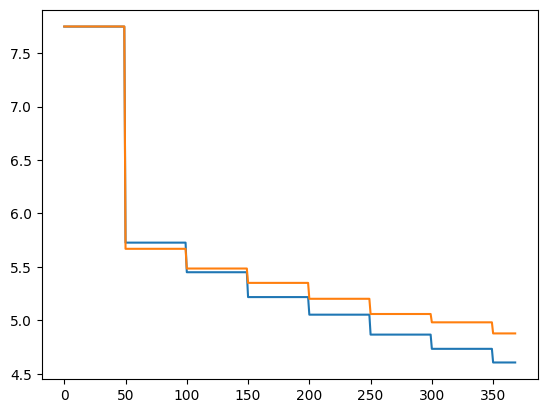

In [47]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(train_lossi))
plt.plot(torch.tensor(val_lossi))

In [48]:
# Generation
model.eval()
@torch.no_grad
def generate(max_tokens=500):
    sample = torch.tensor([tokenizer.encode('\n')], device=device)
    while sample.shape[-1] < max_tokens:
        logits, loss = model(sample[:,:block_size])
        logits = logits[:,-1,:]
        # print(logits.shape)
        probs = F.softmax(logits, dim=-1)
        next_tok = torch.multinomial(probs, 1)
        sample = torch.cat((sample, next_tok), dim=-1)
    return tokenizer.decode(sample[0].cpu().numpy())

print(generate())


O rep:
To my am, my lord, we have so, is thaven.
What.
 will of my loves!




What, his low my pant,


CAMILLO:


Moth in 'dest, sweet.

I amLest, to death?
O,
For as she do quoth, my judant to her arre gons,
You can our royal house to whut'd

But set:
Then begtberpnd, he shall behemry
will, this liishANGELO:

From this flow'd aeed Ie?




Will indeed:


What will'td, Mars shall notullamns the knack;
KING RICHARD III:
Shall,
With Vand the dangers of your eyes.
And give me.
Let night had a tabo God.
To come,
For you should go, Grewited pat often thing
Which thou could noble fack bles,
Nor dispite.
QUEEN ELIZABETH:
IBRUTUS:

 recause,
 I if


 sha
 now sir


 in well in but
 that
 and come to my peace
 I thou

 ' to


 we in my
 do






 by


 and
 know my the
 duty
 I
 pre where
 for go

 there
 the L
 he
 had you

 and and no
 come if

 hepen and
 if R I

 have and

 for

 now and fl go
 that c

 state
 good
 and

 or
 you man
 let
 come


 and

 does I and as a

 die give

 S IThis
